In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit, StratifiedKFold
%matplotlib inline 
sns.set(style="ticks")

In [2]:
data=pd.read_csv('heart.csv', sep=",")

In [3]:
data.shape

(303, 11)

In [4]:
data.dtypes

age         int64
sex         int64
cp          int64
trestbps    int64
chol        int64
restecg     int64
thalach     int64
slope       int64
ca          int64
thal        int64
target      int64
dtype: object

In [5]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
restecg     0
thalach     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
data.head()

,age,sex,cp,trestbps,chol,restecg,thalach,slope,ca,thal,target
0,63,1,3,145,233,0,150,0,0,1,1
1,37,1,2,130,250,1,187,0,0,2,1
2,41,0,1,130,204,0,172,2,0,2,1
3,56,1,1,120,236,1,178,2,0,2,1
4,57,0,0,120,354,1,163,2,0,2,1


Разделение выборки на обучающую и тестовую

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    data, data['target'], test_size= 0.2, random_state= 1)

In [8]:
# Размер обучающей выборки
X_train.shape, y_train.shape

((242, 11), (242,))

In [9]:
# Размер тестовой выборки
X_test.shape, y_test.shape

((61, 11), (61,))

Построим базовые модели на основе метода ближайших соседей

In [10]:
simple_knn = KNeighborsClassifier()

In [11]:
simple_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [12]:
target_1 = simple_knn.predict(X_test)

In [13]:
#оценка моделей с помощью метрик
accuracy_score(y_test, target_1), \
precision_score(y_test, target_1),  \
recall_score(y_test, target_1)

(0.5737704918032787, 0.5675675675675675, 0.6774193548387096)

Построим модели с использованием кросс-валидации

In [14]:
#K-fold:работает в соответствии с определпением кросс-валидации
kfold = cross_val_score(KNeighborsClassifier(), 
                         data, data['target'], 
                         cv=KFold(n_splits=5))
kfold

array([0.47540984, 0.63934426, 0.6557377 , 0.4       , 0.31666667])

In [15]:
#ShuffleSplit: генерирует N случайных перемешиваний данных, в каждом перемешивании заданная доля помещается в тестовую выборку
shufflesplit = cross_val_score(KNeighborsClassifier(), 
                         data, data['target'], 
                         cv=ShuffleSplit(n_splits=5, test_size=0.2))
shufflesplit

array([0.6557377 , 0.6557377 , 0.67213115, 0.63934426, 0.62295082])

In [16]:
#StratifiedKFold: предоставляет индексы для разделения данных, вариант KFold
stratifiedkfold = cross_val_score(KNeighborsClassifier(), 
                         data, data['target'], 
                         cv=StratifiedKFold(n_splits=5))
stratifiedkfold

array([0.60655738, 0.6557377 , 0.57377049, 0.73333333, 0.65      ])

Подбор гиперпараметра К

In [18]:
n_range = np.array(range(1,10,1))
tuned_parameters = [{'n_neighbors': n_range}]
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, 
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
clf_gs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [19]:
clf_gs.best_params_

{'n_neighbors': 3}

Пункт 4 для найденного оптимального значения К

In [20]:
simple_knn2 = KNeighborsClassifier(n_neighbors=3)

In [21]:
simple_knn2.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [22]:
target_2 = simple_knn2.predict(X_test)

In [23]:
accuracy_score(y_test, target_2), \
precision_score(y_test, target_2),  \
recall_score(y_test, target_2)

(0.5901639344262295, 0.575, 0.7419354838709677)

Построить кривые обучения и валидации

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

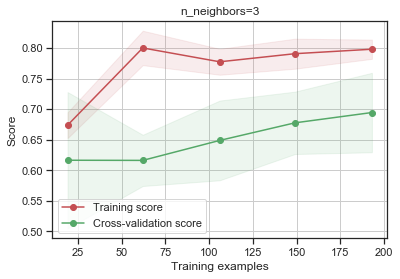

In [25]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=3), 'n_neighbors=3', 
                    X_train, y_train, cv=StratifiedKFold(n_splits=5))

In [26]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

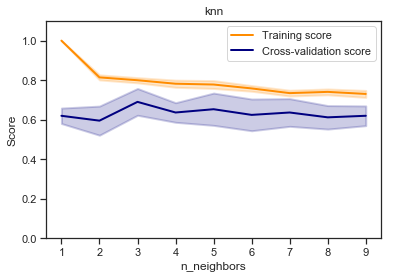

In [27]:
plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      X_train, y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=StratifiedKFold(n_splits=5), scoring="accuracy")